Grades Data

This is  a grades dataset

In [208]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

In [209]:
data = pd.read_csv("data.csv", index_col = 0) ## if dump.json is not available, use dataclean.csv
data.shape

(31568, 53)

First we take a look at the columns of the dataset.
Each observation is a class.

In [210]:
data.columns

Index(['department', 'grade_A', 'grade_Am', 'grade_Ap', 'grade_B', 'grade_Bm',
       'grade_Bp', 'grade_C', 'grade_Cm', 'grade_Cp', 'grade_D', 'grade_Dm',
       'grade_Dp', 'grade_F', 'grade_L', 'grade_R', 'grade_deferred_report',
       'grade_in_progress', 'grade_incomplete', 'grade_no_grade_received',
       'grade_no_pass', 'grade_pass', 'grade_satisfactory',
       'grade_unsatisfactory', 'num_grades', 'num_weighted_grades',
       'professor_course', 'term_quarter', 'term_year', 'total_students',
       'grade_A_pct', 'grade_Am_pct', 'grade_Ap_pct', 'grade_B_pct',
       'grade_Bm_pct', 'grade_Bp_pct', 'grade_C_pct', 'grade_Cm_pct',
       'grade_Cp_pct', 'grade_D_pct', 'grade_Dm_pct', 'grade_Dp_pct',
       'grade_F_pct', 'grade_L_pct', 'grade_R_pct',
       'grade_deferred_report_pct', 'grade_in_progress_pct',
       'grade_incomplete_pct', 'grade_no_grade_received_pct',
       'grade_no_pass_pct', 'grade_pass_pct', 'grade_satisfactory_pct',
       'grade_unsatisfactory_pct']

In [211]:
data[['department','professor_course']].head()

,department,professor_course
0,30,5396
1,30,235
2,30,219
3,30,5399
4,30,383


These numerical values are actually categorical, so we should convert them into dept_name and course_name respectively

In [212]:
jsondata = json.loads(open("./dump.json").read())
prof_course = filter(lambda x: x['model'] == 'professors.professorcourse', jsondata)
courses = filter(lambda x: x['model'] == 'courses.course', jsondata)
professor = filter(lambda x: x['model'] == 'professors.professor', jsondata)
departments = filter(lambda x: x['model'] == 'departments.department', jsondata)
prof_course_mapped = dict([ (pc['pk'], pc) for pc in prof_course ])
professor_mapped = dict([ (pc['pk'], pc) for pc in professor ])
course_mapped = dict([ (pc['pk'], pc) for pc in courses ])
departments_mapped = dict([ (pc['pk'], pc) for pc in departments])

In [213]:
data['dept_name'] = [departments_mapped[x]['fields']['name'].strip() for x in data['department']]
data['dept_short_name'] = [departments_mapped[x]['fields']['short_name'].strip() for x in data['department']]
data['course_name'] = [course_mapped[y]['fields']['name'] for y in [prof_course_mapped[x]['fields']['course'] for x in data['professor_course']]]
data['prof_name'] = [professor_mapped[y]['fields']['slug'] for y in [prof_course_mapped[x]['fields']['professor'] for x in data['professor_course']]]
data.head().loc[:,'dept_name':]

,dept_name,dept_short_name,course_name,prof_name
0,Atmospheric and Oceanic Sciences,A&O SCI,A&O SCI 1,kuo-nan-liou
1,Atmospheric and Oceanic Sciences,A&O SCI,A&O SCI 2,richard-turco
2,Atmospheric and Oceanic Sciences,A&O SCI,A&O SCI 3,jeffrey-lew
3,Atmospheric and Oceanic Sciences,A&O SCI,A&O SCI 19,jeffrey-lew
4,Atmospheric and Oceanic Sciences,A&O SCI,A&O SCI 102,j-david-neelin


In [214]:
## Saving to a new data file with added columns
data.to_csv("dataclean.csv")

Now we want to sort the grades in an order which goes from worst to best

In [138]:
grades = ['F','Dm','D','Dp','Cm','C','Cp','Bm','B','Bp','Am','A','Ap']
gradecols = ['grade_' + s for s in grades]
data.loc[:,gradecols].head()

,grade_F,grade_Dm,grade_D,grade_Dp,grade_Cm,grade_C,grade_Cp,grade_Bm,grade_B,grade_Bp,grade_Am,grade_A,grade_Ap
0,2,2,0,1,4,3,7,5,6,15,8,4,2
1,2,0,4,0,2,24,6,11,49,14,6,45,9
2,3,0,8,6,5,19,8,6,39,19,9,72,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,0,8,10,8,9,14,12,0


In [139]:
gradepctcols = ['grade_' + s + '_pct' for s in grades]
data.loc[:,gradepctcols].head()

,grade_F_pct,grade_Dm_pct,grade_D_pct,grade_Dp_pct,grade_Cm_pct,grade_C_pct,grade_Cp_pct,grade_Bm_pct,grade_B_pct,grade_Bp_pct,grade_Am_pct,grade_A_pct,grade_Ap_pct
0,0.029851,0.029851,0.000000,0.014925,0.059701,0.044776,0.104478,0.074627,0.089552,0.223881,0.119403,0.059701,0.029851
1,0.009569,0.000000,0.019139,0.000000,0.009569,0.114833,0.028708,0.052632,0.234450,0.066986,0.028708,0.215311,0.043062
2,0.014423,0.000000,0.038462,0.028846,0.024038,0.091346,0.038462,0.028846,0.187500,0.091346,0.043269,0.346154,0.004808
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.031746,0.000000,0.126984,0.158730,0.126984,0.142857,0.222222,0.190476,0.000000


In [140]:
data.loc[data[gradecols].sum(axis = 1) != data['total_students']].shape

(14498, 57)

We can plot grade data for each row as a bar plot as follows

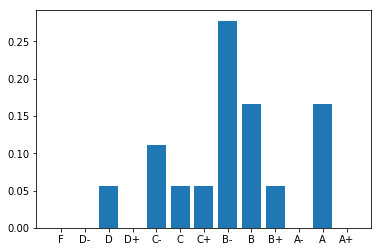

In [141]:
grades2 = ['F','D-','D','D+','C-','C','C+','B-','B','B+','A-','A','A+']
plt.bar(x = grades2, height = data.loc[20,gradepctcols])
plt.show()

The histogram below shows the number of classes against number of letter grades received by students.

The peak at zero indicates that there are about 500 pass no pass classes that we should deal with.

Although there are also some classes with very low letter grades received (< 10) the number of classes like that is exceptionally small so we can be assured that it will not skew our aggregate data analysis by much.

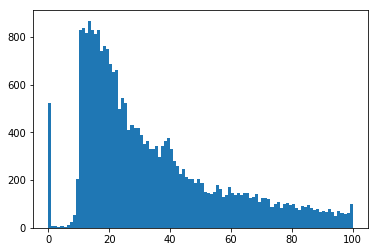

In [142]:
plt.hist(data[gradecols].sum(axis = 1), bins = 100, range = [0,100])
plt.show()

In [143]:
data.loc[data.loc[:,gradecols].sum(axis = 1) == 0].shape

(524, 57)

We notice that 524 classes are P/NP classes and should be dealt with separately.

Also, note that students who opt to pass / no pass a class should be excluded because they would skew results by perhaps not putting as much effort into a class as they would otherwise.

As such, we should split the data into pass-no-pass classes and letter grade classes.

In [144]:
pnpdata = data.loc[data.loc[:,gradecols].sum(axis = 1) == 0]
lgdata = data.loc[~(data.loc[:,gradecols].sum(axis = 1) == 0)]

Some initial questions to consider:
    - Is grade inflation a thing?
    - Are there professors who are more lenient than others?
    - Are certain departments more competitive than others?
    - Does the weather/seasons affect grade distributions?
    
In order the answer these questions, it might make sense to convert each grade into a GPA to get better numerical results such as the mean, median, quantiles and standard deviations of these distributions.

We will map GPA using the grade point scale found here: https://catalog.registrar.ucla.edu/ucla-catalog18-19-117.html

In [145]:
gradepts = [0,0.7,1.0,1.3,1.7,2.0,2.3,2.7,3.0,3.3,3.7,4.0,4.0]
gradedict = dict(zip(grades2,gradepts))
gradedict

{'F': 0,
 'D-': 0.7,
 'D': 1.0,
 'D+': 1.3,
 'C-': 1.7,
 'C': 2.0,
 'C+': 2.3,
 'B-': 2.7,
 'B': 3.0,
 'B+': 3.3,
 'A-': 3.7,
 'A': 4.0,
 'A+': 4.0}

For each observation, we extract its summary statistics

In [146]:
dist = [[gradepts[i]]*x for i,x in enumerate(data.loc[0,gradecols])]
raw = pd.Series([x for y in dist for x in y])
raw.describe()

count    59.000000
mean      2.816949
std       0.968496
min       0.000000
25%       2.300000
50%       3.000000
75%       3.300000
max       4.000000
dtype: float64

We put the above into a function and apply it over each row

In [147]:
def summstats(row):
    dist = [[gradepts[i]]*x for i,x in enumerate(row)]
    raw = pd.Series([x for y in dist for x in y])
    return(raw.describe())

In [148]:
## We will only apply it on the head for reference
lgdata.loc[:,gradecols].head().apply(summstats, axis = 1)

,count,mean,std,min,25%,50%,75%,max
0,59.0,2.816949,0.968496,0.0,2.3,3.0,3.3,4.0
1,172.0,3.083140,0.845771,0.0,2.7,3.0,4.0,4.0
2,195.0,3.086667,0.978915,0.0,2.5,3.3,4.0,4.0
4,63.0,3.211111,0.635790,1.7,2.7,3.3,3.7,4.0
5,63.0,3.471429,0.781113,0.0,3.3,3.7,4.0,4.0


Lets dive deeper into the data and see what kind of groupings we can get based on:
    - Term Quarter
    - Term Year

In [149]:
byTermYear = lgdata.groupby('term_year')[gradecols].sum().apply(summstats, axis = 1)
byTermYear

,count,mean,std,min,25%,50%,75%,max
term_year,,,,,,,,
2006,156260.0,3.163241,0.840706,0.0,2.7,3.3,4.0,4.0
2009,91144.0,3.188597,0.842559,0.0,2.7,3.3,4.0,4.0
2010,164337.0,3.226533,0.832589,0.0,3.0,3.3,4.0,4.0
2012,90511.0,3.203513,0.846366,0.0,2.7,3.3,4.0,4.0
2013,283815.0,3.232407,0.844706,0.0,3.0,3.3,4.0,4.0
2014,292149.0,3.246556,0.840442,0.0,3.0,3.3,4.0,4.0
2015,299388.0,3.264102,0.836828,0.0,3.0,3.7,4.0,4.0
2016,331840.0,3.306672,0.819213,0.0,3.0,3.7,4.0,4.0
2017,307304.0,3.325938,0.812562,0.0,3.0,3.7,4.0,4.0


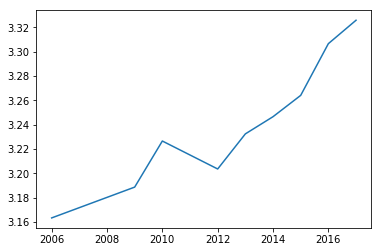

In [150]:
plt.plot(byTermYear.index, byTermYear['mean'])

From the above graph, we can clearly see an upward trend in terms of the total mean GPA received over the year. This seems to indicate a strong case for GPA inflation.

In [151]:
byTermQtr = lgdata.groupby('term_quarter')[gradecols].sum().apply(summstats, axis = 1)
byTermQtr

,count,mean,std,min,25%,50%,75%,max
term_quarter,,,,,,,,
FA,763513.0,3.241651,0.830726,0.0,3.0,3.3,4.0,4.0
SP,575498.0,3.262474,0.838594,0.0,3.0,3.7,4.0,4.0
SU,121031.0,3.313068,0.876166,0.0,3.0,3.7,4.0,4.0
WI,556706.0,3.258460,0.823600,0.0,3.0,3.3,4.0,4.0


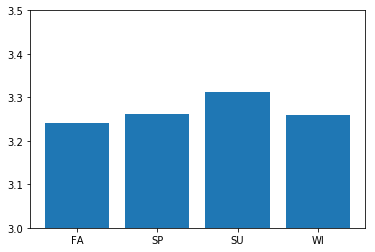

In [152]:
plt.bar(byTermQtr.index, byTermQtr['mean'])
plt.ylim(3,3.5)
plt.show()

From the histogram above, we can also see that classes taught in the summer tend to give out higher grades

In [166]:
byProf = lgdata.groupby('prof_name')[gradecols].sum().apply(summstats, axis = 1)

Index(['a-b-kaplan', 'a-c-quicoli', 'a-collis', 'a-cong-huyen',
       'a-f-salamanca', 'a-grant-friedman', 'a-j-liszkiewicz', 'a-keshishian',
       'a-l-hernandez', 'a-l-silver-1',
       ...
       'ying-nian-wu', 'yingnian-wu', 'yoh-kawano', 'yona-sabar', 'yongjie-hu',
       'yvette-martinez-vu', 'z-a-kramer', 'zachary-taylor',
       'zarah-sophia-ersoff', 'zeynep-korkman'],
      dtype='object', name='prof_name', length=1304)

In [204]:
byProf[byProf['count'] > 500].sort_values('mean',ascending = False).head()

,count,mean,std,min,25%,50%,75%,max
prof_name,,,,,,,,
i-nyoman-wenten,851.0,3.999295,0.014535,3.7,4.0,4.0,4.0,4.0
donald-neuen,1266.0,3.987046,0.114649,1.7,4.0,4.0,4.0,4.0
john-b-ullmen,541.0,3.986876,0.097343,3.0,4.0,4.0,4.0,4.0
chuc-v-bui,553.0,3.986618,0.069691,3.3,4.0,4.0,4.0,4.0
abhiman-kaushal,1595.0,3.982194,0.151269,0.0,4.0,4.0,4.0,4.0


We have found a professor who gives almost all A/A+ for his ETHNOMU 161B class

In [202]:
lgdata.loc[lgdata['prof_name'] == 'i-nyoman-wenten', gradecols + ['prof_name','course_name']]

,grade_F,grade_Dm,grade_D,grade_Dp,grade_Cm,grade_C,grade_Cp,grade_Bm,grade_B,grade_Bp,grade_Am,grade_A,grade_Ap,prof_name,course_name
3041,0,0,0,0,0,0,0,0,0,0,0,25,2,i-nyoman-wenten,ETHNOMU 161B
4379,0,0,0,0,0,0,0,0,0,0,0,50,1,i-nyoman-wenten,ETHNOMU 161B
5771,0,0,0,0,0,0,0,0,0,0,0,45,2,i-nyoman-wenten,ETHNOMU 161B
7717,0,0,0,0,0,0,0,0,0,0,0,36,3,i-nyoman-wenten,ETHNOMU 161B
9630,0,0,0,0,0,0,0,0,0,0,0,37,1,i-nyoman-wenten,ETHNOMU 161B
10884,0,0,0,0,0,0,0,0,0,0,0,38,1,i-nyoman-wenten,ETHNOMU 161B
12194,0,0,0,0,0,0,0,0,0,0,0,35,2,i-nyoman-wenten,ETHNOMU 161B
14224,0,0,0,0,0,0,0,0,0,0,0,8,1,i-nyoman-wenten,ETHNOMU 91B
14225,0,0,0,0,0,0,0,0,0,0,0,50,1,i-nyoman-wenten,ETHNOMU 161B
15523,0,0,0,0,0,0,0,0,0,0,0,41,3,i-nyoman-wenten,ETHNOMU 161B


In [184]:
byCourse = lgdata.groupby('course_name')[gradecols].sum().apply(summstats, axis = 1)

In [200]:
byCourse[byCourse['count'] > 500].sort_values('mean', ascending = False).head()

,count,mean,std,min,25%,50%,75%,max
course_name,,,,,,,,
ETHNOMU 161B,643.0,3.999067,0.016718,3.7,4.0,4.0,4.0,4.0
LIFESCI 192B,609.0,3.997537,0.027093,3.7,4.0,4.0,4.0,4.0
MUSIC 90F,667.0,3.990255,0.161574,0.0,4.0,4.0,4.0,4.0
SOC WLF 195,593.0,3.988364,0.074090,3.0,4.0,4.0,4.0,4.0
ETHNOMU 161F,828.0,3.983937,0.094698,3.0,4.0,4.0,4.0,4.0


Again we notice that ETHNOMU 161B comes up, but we also see LIFESCI 192B